# FINM 25000 - Quantitative Portfolio Management and Algorithmic Trading
## Homework 3 Solution | Summer 2022

In [1]:
# Start by importing the packages and datasets for this week's homework

import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


factors = pd.read_excel('factor_pricing_data.xlsx', 'factors (excess)').set_index("Date")
portfolios = pd.read_excel('factor_pricing_data.xlsx', 'assets (excess)').set_index("Date")



def performanceMetrics(returns,annualization=1, quantile=.05):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    return metrics



def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    
    #Maximum Drawdown
    def maximumDrawdown(returns):
        cum_returns = (1 + returns).cumprod()
        rolling_max = cum_returns.cummax()
        drawdown = (cum_returns - rolling_max) / rolling_max

        max_drawdown = drawdown.min()
        end_date = drawdown.idxmin()
        summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

        for col in drawdown:
            summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
            recovery = (drawdown.loc[end_date[col]:,col])
            try:
                summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
            except:
                summary.loc[col,'Recover'] = pd.to_datetime(None)

            summary['Peak'] = pd.to_datetime(summary['Peak'])
            try:
                summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
            except:
                summary['Duration (to Recover)'] = None

            summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

        return summary  
    
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] = (metrics['Max Drawdown'] - returns.mean())/returns.std()

    return metrics


def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

## 2. Pricing Factors and Assets

#### 1. The Factors. Calculate their univariate performance statistics:
    - mean
    - volatility
    - Sharpe
    - VaR(.05)

Does each factor have a premium (positive expected excess return)?


In [2]:
perform_metrics = performanceMetrics(factors, annualization=12)
tail_metrics = tailMetrics(factors)
rets_met = pd.concat([perform_metrics[['Mean', 'Vol', 'Sharpe']], tail_metrics[['VaR (0.05)']]], axis = 1)
display(rets_met.style.\
        format(formatter = {'Mean' : '{:,.2%}', 'Vol' : '{:,.2%}', 'Sharpe' : '{:,.2f}', 'VaR (0.05)' : '{:,.2%}'}))

,Mean,Vol,Sharpe,VaR (0.05)
MKT,8.43%,15.19%,0.56,-7.65%
SMB,1.21%,10.96%,0.11,-4.29%
HML,1.82%,11.10%,0.16,-4.16%
UMD,5.74%,16.34%,0.35,-7.12%


Historical data shows that each factor has recieved a positive risk premium

#### 2. The factors are constructed in such a way as to reduce correlation between them. Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small?

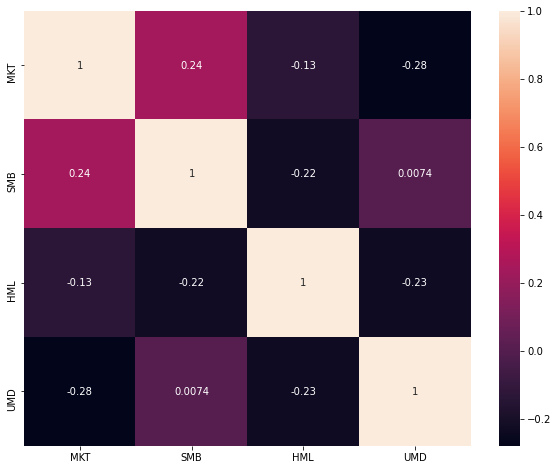

In [3]:
corr_matrix = factors.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

Yes, factor correlations are relatively small with max correlation of around -0.3. 

#### 3. Plot the cumulative returns of the factors.

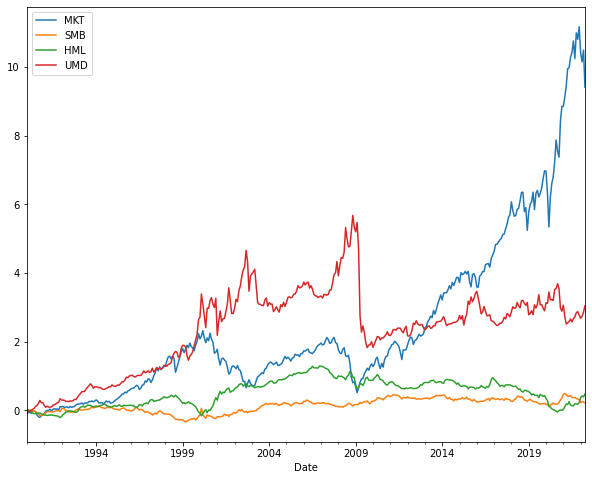

In [4]:
cum_rets = (1+factors).cumprod() - 1
cum_rets.plot(figsize = (10, 8))
plt.show()

#### 4. Test assets.
The “assets” tab provides monthly excess return data on various industry stock-portfolios. Denote these as ri, for n = 1,...,12. Calculate the (annualized) univariate statistics from 1.1.

In [5]:
perform_metrics_assets = performanceMetrics(portfolios, annualization=12)
tail_metrics_assets = tailMetrics(portfolios)
rets_met_assets = pd.concat([perform_metrics_assets[['Mean', 'Vol', 'Sharpe']], tail_metrics_assets[['VaR (0.05)']]], axis = 1)
display(rets_met_assets.style.\
        format(formatter = {'Mean' : '{:,.2%}', 'Vol' : '{:,.2%}', 'Sharpe' : '{:,.2f}', 'VaR (0.05)' : '{:,.2%}'}))

,Mean,Vol,Sharpe,VaR (0.05)
NoDur,8.58%,13.18%,0.65,-5.73%
Durbl,10.65%,27.02%,0.39,-11.21%
Manuf,10.10%,18.47%,0.55,-8.41%
Enrgy,8.70%,22.01%,0.40,-9.55%
Chems,8.59%,14.79%,0.58,-7.16%
BusEq,12.49%,23.53%,0.53,-11.11%
Telcm,5.48%,17.52%,0.31,-8.98%
Utils,7.50%,13.83%,0.54,-6.29%
Shops,9.68%,16.05%,0.60,-7.19%
Hlth,9.70%,15.33%,0.63,-7.28%


#### 5. Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their VaR(.05) statistics?

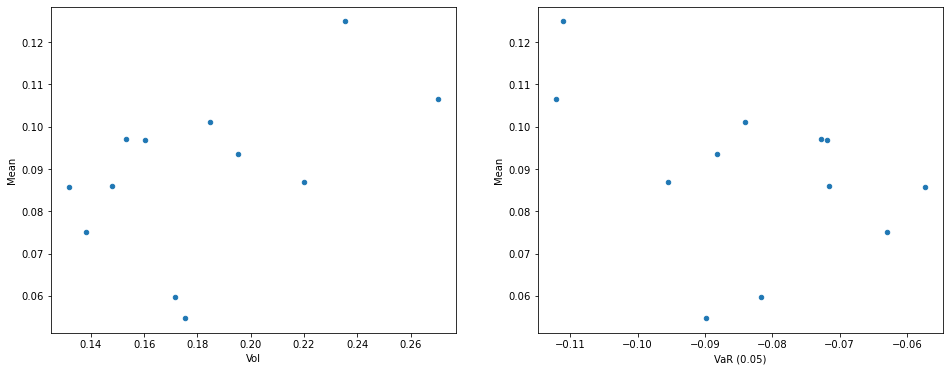

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))
rets_met_assets.plot.scatter('Vol', 'Mean', ax = ax[0])
rets_met_assets.plot.scatter('VaR (0.05)', 'Mean', ax = ax[1])
plt.show()

If portfolio volatilities could explain the difference in mean excess returns, an increase in the portfolio vol would mean an increase in the mean return. Clearly, from the mean-vol chart above, we do not observe this monotonic trend. Same is true when looking at mean-VaR chart (increase in VaR should decrease mean return). This shows that investors care about factors which are different than idosyncratic risk measures while pricing these assets.

## 3. CAPM

#### 1. For each of the n = 12 test assets, run the CAPM time-series regression

In [7]:
capm_ts = get_ols_metrics(factors['MKT'], portfolios, annualization=12, ignorenan=True)

#### 2. Report the estimated $\beta^{i,mkt}$ Treynor Ratio, $\alpha^i$, and Information Ratio for each of the n regressions.

In [8]:
display(capm_ts.style.format(formatter = {'alpha' : '{:,.2%}', 'MKT' : '{:,.2f}', 'r-squared' : '{:,.2%}',\
                             'Treynor Ratio' : '{:,.2f}', 'Info Ratio' : '{:,.2f}'}))

,alpha,MKT,r-squared,Treynor Ratio,Info Ratio
NoDur,3.26%,0.63,52.85%,0.14,0.36
Durbl,-0.83%,1.36,58.50%,0.08,-0.05
Manuf,0.80%,1.10,82.31%,0.09,0.10
Enrgy,1.58%,0.84,33.93%,0.10,0.09
Chems,2.13%,0.77,61.94%,0.11,0.23
BusEq,1.23%,1.34,74.29%,0.09,0.10
Telcm,-2.31%,0.92,64.17%,0.06,-0.22
Utils,4.05%,0.41,20.19%,0.18,0.33
Shops,2.13%,0.89,71.60%,0.11,0.25
Hlth,3.62%,0.72,51.05%,0.13,0.34


#### 3. If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

If CAPM were true, the following would hold as well:

1. Treynor Ratio for all assets would the same, and equal to the market premium
2. Alpha should be zero
3. Information Ratio should be zero

#### 4. Calculate the mean absolute error of the estimated alphas. If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?

In [9]:
print('Mean-Absolute-Error from CAPM: {:,.2%}'.format(capm_ts.alpha.abs().mean()))

Mean-Absolute-Error from CAPM: 2.08%


If CAPM was true, alpha estimates would be relatively small compared to the mean returns. As per CAPM, there should be no excess return compared to the market. However, given the large MAE stat, this is not supported in the data.

## 4. A multifactor model

#### 1. For each regression, report the estimated α and r-squared.

In [10]:
mfm_ts = get_ols_metrics(factors, portfolios, annualization=12, ignorenan=True)
display(mfm_ts.style.format(formatter = {'alpha' : '{:,.2%}', 'r-squared' : '{:,.2%}','MKT' : '{:,.2f}',\
                                         'SMB' : '{:,.2f}', 'HML' : '{:,.2f}', 'UMD' : '{:,.2f}', 'Info Ratio' : '{:,.2f}'}))

,alpha,MKT,SMB,HML,UMD,r-squared,Info Ratio
NoDur,2.58%,0.69,-0.22,0.18,0.02,59.28%,0.31
Durbl,0.29%,1.28,0.23,0.39,-0.25,64.51%,0.02
Manuf,0.72%,1.09,0.10,0.27,-0.07,85.69%,0.10
Enrgy,-0.25%,0.89,0.10,0.66,0.01,44.40%,-0.01
Chems,1.62%,0.81,-0.17,0.21,-0.01,66.83%,0.19
BusEq,3.92%,1.21,0.18,-0.64,-0.11,84.19%,0.42
Telcm,-1.79%,0.93,-0.17,-0.04,-0.06,65.45%,-0.17
Utils,2.19%,0.51,-0.22,0.31,0.12,30.39%,0.19
Shops,2.27%,0.89,-0.03,-0.01,-0.02,71.67%,0.27
Hlth,3.42%,0.76,-0.20,-0.15,0.07,54.22%,0.33


#### 2. Calculate the mean absolute error of the estimated alphas. If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?

In [11]:
print('Mean-Absolute-Error: {:,.2%}'.format(mfm_ts.alpha.abs().mean()))

Mean-Absolute-Error: 1.92%


Again, If the pricing model was accurate, alpha estimates would be relatively small, even close to zero. However, given the large MAE stat, this is not supported in the data.